# Analysis of DNA-MERFISH for CTP11,12,13

by Pu Zheng

2022.07.07

analysis for dataset:

dna_data_folder = r'\\10.245.74.158\Chromatin_NAS_4\20220316-P_brain_CTP11-12-13_from_0304'

rna_data_folder = r'\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors'

save_folder = r'\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\20220316-P_brain_CTP11-12-13_from_0304'

In [46]:
%run "..\..\Startup_py3.py"
sys.path.append(r"..\..\..\..\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

1272


## 0.1 Folders

In [47]:
save_folder = r'\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\20220316-P_brain_CTP11-12-13_from_0304'
save_filenames = [os.path.join(save_folder, _fl) for _fl in os.listdir(save_folder)
                  if _fl.split(os.extsep)[-1]=='hdf5']
# extract fov_id
save_fov_ids = [int(os.path.basename(_fl).split('.hdf5')[0].split('_')[-1]) for _fl in save_filenames]

debug = False

print(f"{len(save_filenames)} fovs detected")

analysis_folder = os.path.join(save_folder, 'Analysis_0706')

segmentation_folder = os.path.join(analysis_folder, 'Segmentation')
if not os.path.exists(segmentation_folder):
    os.makedirs(segmentation_folder)
    print(f"Creating segmentation_folder: {segmentation_folder}")
else:
    print(f"Use segmentation_folder: {segmentation_folder}")

cand_spot_folder = os.path.join(analysis_folder, 'CandSpots')
if not os.path.exists(cand_spot_folder):
    os.makedirs(cand_spot_folder)
    print(f"Creating cand_spot_folder: {cand_spot_folder}")
else:
    print(f"Use cand_spot_folder: {cand_spot_folder}")

decoder_folder = cand_spot_folder.replace('CandSpots', 'Decoder')
if debug:
    _version = 0
    while os.path.exists(os.path.join(decoder_folder, f'v{_version}')):
        _version += 1
    decoder_folder = os.path.join(decoder_folder, f'v{_version}')
if not os.path.exists(decoder_folder):
    os.makedirs(decoder_folder)
    print(f"Creating decoder_folder: {decoder_folder}")
else:
    print(f"Use decoder_folder: {decoder_folder}")
    
picked_folder = os.path.join(analysis_folder, 'Picked_v1')
if not os.path.exists(picked_folder):
    os.makedirs(picked_folder)
    print(f"Creating picked_folder: {picked_folder}")
else:
    print(f"Use picked_folder: {picked_folder}")

168 fovs detected
Use segmentation_folder: \\10.245.74.158\Chromatin_NAS_8\Analyzed_data\20220316-P_brain_CTP11-12-13_from_0304\Analysis_0706\Segmentation
Use cand_spot_folder: \\10.245.74.158\Chromatin_NAS_8\Analyzed_data\20220316-P_brain_CTP11-12-13_from_0304\Analysis_0706\CandSpots
Use decoder_folder: \\10.245.74.158\Chromatin_NAS_8\Analyzed_data\20220316-P_brain_CTP11-12-13_from_0304\Analysis_0706\Decoder
Creating picked_folder: \\10.245.74.158\Chromatin_NAS_8\Analyzed_data\20220316-P_brain_CTP11-12-13_from_0304\Analysis_0706\Picked_v1


pixel_sizes = np.array([250,108,108])
single_im_size = np.array([50,2048,2048])

# 1. Decoding of DNA-MERFISH

In [1]:
# load two codebooks
import pandas as pd

ctp11_codebook = pd.read_csv(r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\Summary_tables\CTP11-1000_codebook_probe.csv', header=0)
ctp13_codebook = pd.read_csv(r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\Summary_tables\CTP13-mop_SE_1000.csv', header=0)
ctp13_codebook

,name,id,NDB_376,NDB_578,NDB_400,NDB_533,NDB_568,NDB_464,NDB_466,NDB_431,...,NDB_608,NDB_460,NDB_563,NDB_592,NDB_368,NDB_436,NDB_629,NDB_604,chr,chr_order
0,1:9627926-9637875,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0.0
1,1:9799472-9811359,2,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,1.0
2,1:20920666-20929358,3,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,2.0
3,1:21522568-21534512,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,3.0
4,1:21732182-21745770,5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
961,X:101961397-101974103,987,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,X,2.0
962,X:136808741-136818926,988,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,X,3.0
963,X:140517829-140527051,989,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,X,4.0
964,X:167157164-167167452,990,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,X,5.0


## Load bit_2_name

In [50]:
readout_df_gn = pd.read_csv(r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\Summary_tables\CTP11-mouse-genome-1000_combo_readouts.csv')
readout_df_se = pd.read_csv(r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\Summary_tables\CTP13-mouse-SE_combo_readouts.csv')

# merge
readout_df_se['Bit']+=100
readout_df = pd.concat([readout_df_gn, readout_df_se])
readout_df

,Bit,ReadoutName
0,1,NDB_784
1,2,NDB_755
2,3,NDB_826
3,4,NDB_713
4,5,NDB_865
...,...,...
90,191,NDB_592
91,192,NDB_368
92,193,NDB_436
93,194,NDB_629


## 3.3 prepare kwargs to decode CTP11

In [51]:
%%time
from tqdm import tqdm
from ImageAnalysis3.classes import new_decoder
reload(ia.classes.new_decoder)
from ImageAnalysis3.classes.new_decoder import batch_process_SpotDecoder

overwrite_decoder = True
verbose_decoder = True
return_decoder = False

pair_search_radius = 300
pair_search_eps = 0.25
ctp11_data_type = 'combo'
ctp11_lib_name = 'CTP11'
ctp11_decode_args = []
for _fov_id, _save_filename in zip(save_fov_ids, save_filenames):
    print(f"- Preparing decoding args for fov: {_fov_id},", end=' ')
    # load candidate spots for the fov
    cand_spot_filename = os.path.join(cand_spot_folder, ctp11_data_type,
                                      os.path.basename(_save_filename).replace('.hdf5', f'_CandSpots.csv') )
    if os.path.isfile(cand_spot_filename):
        _fov_spots_df = pd.read_csv(cand_spot_filename)
    else:
        continue # skip if fov doesn't exist
        
    for _cell_id in np.unique(_fov_spots_df['cell_id']):
        # get decoder filename
        _decoder_filename = os.path.join(decoder_folder, f"Decoded_fov-{_fov_id}_cell-{_cell_id}.hdf5")
        # check if overwrite:
        if not overwrite_decoder and os.path.exists(_decoder_filename):
            # skip if exists
            with h5py.File(_decoder_filename, 'r') as _f:
                if ctp11_lib_name in _f.keys():
                    continue
        # get cell_df
        _cell_spots_df =_fov_spots_df[_fov_spots_df['cell_id']==_cell_id]
        # prepare args
        ctp11_decode_args.append(
            (ctp11_lib_name, _cell_spots_df, ctp11_codebook, readout_df, _decoder_filename,
             pair_search_radius, pair_search_eps, overwrite_decoder, verbose_decoder, return_decoder)
        )
    print(len(ctp11_decode_args))

- Preparing decoding args for fov: 0, 112
- Preparing decoding args for fov: 1, 278
- Preparing decoding args for fov: 2, 319
- Preparing decoding args for fov: 3, 529
- Preparing decoding args for fov: 4, 717
- Preparing decoding args for fov: 5, 926
- Preparing decoding args for fov: 6, 1097
- Preparing decoding args for fov: 7, 1255
- Preparing decoding args for fov: 8, 1416
- Preparing decoding args for fov: 9, 1553
- Preparing decoding args for fov: 10, 1699
- Preparing decoding args for fov: 11, 1854
- Preparing decoding args for fov: 12, 2005
- Preparing decoding args for fov: 13, 2183
- Preparing decoding args for fov: 14, 2347
- Preparing decoding args for fov: 15, 2521
- Preparing decoding args for fov: 16, 2735
- Preparing decoding args for fov: 17, 2940
- Preparing decoding args for fov: 18, 2981
- Preparing decoding args for fov: 19, 3080
- Preparing decoding args for fov: 20, 3314
- Preparing decoding args for fov: 21, 3539
- Preparing decoding args for fov: 22, 3731
- Pr

KeyboardInterrupt: 

## Test decoding for one cell

In [7]:
%matplotlib inline
from ImageAnalysis3.classes.new_decoder import batch_process_SpotMapper, batch_process_SpotDecoder
sel_cell = 10

# conbinatorial
batch_process_SpotDecoder(*ctp11_decode_args[sel_cell])
#batch_process_SpotDecoder(*ctp13_decode_args[sel_cell])
# sequential
#batch_process_SpotMapper(*ctp12_decode_args[sel_cell])

- Load decoder from file: \\10.245.74.158\Chromatin_NAS_8\Analyzed_data\20220316-P_brain_CTP11-12-13_from_0304\Analysis_0706\Decoder\Decoded_fov-0_cell-12.hdf5
-- savefile:\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\20220316-P_brain_CTP11-12-13_from_0304\Analysis_0706\Decoder\Decoded_fov-0_cell-12.hdf5 not exist, skip
- Matching 194 bits to (988, 103) codebook


E:\Users\puzheng\Documents\ImageAnalysis3\classes\new_decoder.py:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.bit_codebook[_matched_bit[0]] = self.codebook[_col].copy()


-- 99 bits matched
- Process (988, 102) codebook into valid pairs
-- 2964 valid pairs detected.
- Searching for spot-pairs within 300nm.
-- find candidate pairs by KDTree
-- filter candidate pairs by codebook
-- 14151 pairs selected.
- Select spot_groups from candidate pairs with radius:300, max_usage=1
-- calculate scores for candSpotPairs


 87%|███████████████████████████████████████████████████████████████████▋          | 12276/14151 [00:00<00:00, 122668.58it/s]

-- 1440 full tuples selected


100%|██████████████████████████████████████████████████████████████████████████████| 14151/14151 [00:00<00:00, 121900.25it/s]


-- 1293 pairs selected
-- in total 2733 spot_groups detected
- Save decoder of CTP11 into file: \\10.245.74.158\Chromatin_NAS_8\Analyzed_data\20220316-P_brain_CTP11-12-13_from_0304\Analysis_0706\Decoder\Decoded_fov-0_cell-12.hdf5
-- existing info: [] and []
-- save bits
-- save search_radius to attrs
-- save search_eps to attrs
-- save readoutDf
-- save codebook
-- save candSpots
-- save spotGroups


E:\Users\puzheng\Documents\ImageAnalysis3\classes\new_decoder.py:388: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block4_values] [items->Index(['uid', 'homolog', 'channel_0', 'channel_1', 'channel_2', 'region_name',
       'start', 'end', 'chr'],
      dtype='object')]

  _spotGroupDf.to_hdf(self.saveFile, f'{self.codebook_name}/spotGroups', complevel=_complevel, complib=_complib)


- Save spot_stats iamage to file: \\10.245.74.158\Chromatin_NAS_8\Analyzed_data\20220316-P_brain_CTP11-12-13_from_0304\Analysis_0706\Decoder\Decoded_fov-0_cell-12_CTP11_stats.png


## Plot decoded spots

In [8]:
import matplotlib
import matplotlib.pyplot as plt
plt.rc('font', family='serif')
plt.rc('font', serif='Arial')
plt.style.use('dark_background')

matplotlib.rcParams['pdf.fonttype'] = 42

In [9]:
decoded_figure_folder = os.path.join(decoder_folder, 'Decoded_3D_figures')
print(decoded_figure_folder)
if not os.path.exists(decoded_figure_folder):
    os.makedirs(decoded_figure_folder)

\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\20220316-P_brain_CTP11-12-13_from_0304\Analysis_0706\Decoder\Decoded_3D_figures


<IPython.core.display.Javascript object>


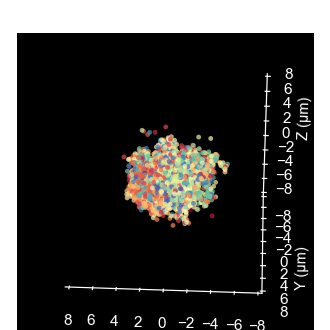

In [10]:
%matplotlib notebook
sel_lib = 'CTP11'
_decoded_groups = pd.read_hdf(ctp11_decode_args[sel_cell][4], f'{sel_lib}/spotGroups')
_zxys = _decoded_groups[['center_z', 'center_x', 'center_y']].values / 1000
_zxys = _zxys - np.nanmean(_zxys, axis=0)
_rids = _decoded_groups['region_id'].values

figure_width = 3
figure_dpi=100
marker_size = 10
marker_alpha = 0.7
_font_size = 7.5
plot_radius = 8
background_color = [0,0,0]
depthshade=False

fig = plt.figure(figsize=(figure_width, figure_width), dpi=figure_dpi)

ax3d = fig.add_subplot(111, projection='3d')
ax3d.set_facecolor(background_color)
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.9)
# turn off grid if needed
ax3d.grid(False)
ax3d.xaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax3d.yaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax3d.zaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))

_valid_inds = (np.isnan(_zxys).sum(1) == 0)
_sc = ax3d.scatter(_zxys[_valid_inds,1], _zxys[_valid_inds,2], _zxys[_valid_inds,0],
                   c=_rids, cmap='Spectral',
                   s=marker_size, depthshade=depthshade, 
                   alpha=marker_alpha,
                   linewidth=0,)
# axes limits
ax3d.axes.set_xlim3d(left=-plot_radius, right=plot_radius) 
ax3d.axes.set_ylim3d(bottom=-plot_radius, top=plot_radius) 
ax3d.axes.set_zlim3d(bottom=-plot_radius, top=plot_radius) 
# axes ticks
ax3d.set_xticks(np.arange(-plot_radius,plot_radius+1, 2))
ax3d.set_yticks(np.arange(-plot_radius,plot_radius+1, 2))
ax3d.set_zticks(np.arange(-plot_radius,plot_radius+1, 2))
# axes labels
ax3d.set_xlabel(f"X (\u03BCm)", fontsize=_font_size+2, labelpad=1)
ax3d.set_ylabel(f"Y (\u03BCm)", fontsize=_font_size+2, labelpad=1)
ax3d.set_zlabel(f"Z (\u03BCm)", fontsize=_font_size+2, labelpad=1)

# save pdf and png
fig.savefig(os.path.join(decoded_figure_folder, 
                         f"{os.path.basename(ctp11_decode_args[sel_cell][4]).replace('.hdf5', f'_decoded_{sel_lib}.png')}"),
            transparent=True)

# Process All

In [11]:
%%time
from ImageAnalysis3.classes.new_decoder import batch_process_SpotDecoder
import multiprocessing as mp
print(len(ctp11_decode_args))
with mp.Pool(32) as decode_pool:
    decode_results = decode_pool.starmap(batch_process_SpotDecoder, ctp11_decode_args, chunksize=1)
    decode_pool.close()
    decode_pool.join()
    decode_pool.terminate()

29050
Wall time: 1h 42min 25s


In [12]:
# Delete args to release RAM
del(ctp11_decode_args)
del(decode_results)

## 3.4 prepare kwargs to decode CTP13

In [17]:
%%time
from tqdm import tqdm
from ImageAnalysis3.classes import new_decoder
reload(ia.classes.new_decoder)
from ImageAnalysis3.classes.new_decoder import batch_process_SpotDecoder

overwrite_decoder = False
verbose_decoder = True
return_decoder = False

pair_search_radius = 300
pair_search_eps = 0.25
ctp13_data_type = 'combo'
ctp13_lib_name = 'CTP13'
ctp13_decode_args = []
for _fov_id, _save_filename in zip(save_fov_ids, save_filenames):
    print(f"- Preparing decoding args for fov: {_fov_id},", end=' ')
    # load candidate spots for the fov
    cand_spot_filename = os.path.join(cand_spot_folder, ctp13_data_type,
                                      os.path.basename(_save_filename).replace('.hdf5', f'_CandSpots.csv') )
    if os.path.isfile(cand_spot_filename):
        _fov_spots_df = pd.read_csv(cand_spot_filename)
    else:
        continue # skip if fov doesn't exist
        
    for _cell_id in np.unique(_fov_spots_df['cell_id']):
        # get decoder filename
        _decoder_filename = os.path.join(decoder_folder, f"Decoded_fov-{_fov_id}_cell-{_cell_id}.hdf5")
        # check if overwrite:
        if not overwrite_decoder and os.path.exists(_decoder_filename):
            # skip if exists
            with h5py.File(_decoder_filename, 'r') as _f:
                if ctp13_lib_name in _f.keys():
                    continue
        # get cell_df
        _cell_spots_df =_fov_spots_df[_fov_spots_df['cell_id']==_cell_id]
        # prepare args
        ctp13_decode_args.append(
            (ctp13_lib_name, _cell_spots_df, ctp13_codebook, readout_df, _decoder_filename,
             pair_search_radius, pair_search_eps, overwrite_decoder, verbose_decoder, return_decoder)
        )
    print(len(ctp13_decode_args))

- Preparing decoding args for fov: 0, 111
- Preparing decoding args for fov: 1, 277
- Preparing decoding args for fov: 2, 318
- Preparing decoding args for fov: 3, 528
- Preparing decoding args for fov: 4, 716
- Preparing decoding args for fov: 5, 925
- Preparing decoding args for fov: 6, 1096
- Preparing decoding args for fov: 7, 1254
- Preparing decoding args for fov: 8, 1415
- Preparing decoding args for fov: 9, 1552
- Preparing decoding args for fov: 10, 1698
- Preparing decoding args for fov: 11, 1853
- Preparing decoding args for fov: 12, 2004
- Preparing decoding args for fov: 13, 2182
- Preparing decoding args for fov: 14, 2346
- Preparing decoding args for fov: 15, 2520
- Preparing decoding args for fov: 16, 2734
- Preparing decoding args for fov: 17, 2939
- Preparing decoding args for fov: 18, 2980
- Preparing decoding args for fov: 19, 3079
- Preparing decoding args for fov: 20, 3313
- Preparing decoding args for fov: 21, 3538
- Preparing decoding args for fov: 22, 3730
- Pr

## Test decoding the same cell

In [14]:
%matplotlib inline
from ImageAnalysis3.classes.new_decoder import batch_process_SpotMapper, batch_process_SpotDecoder

# conbinatorial
#batch_process_SpotDecoder(*ctp11_decode_args[sel_cell])
batch_process_SpotDecoder(*ctp13_decode_args[sel_cell])
# sequential
#batch_process_SpotMapper(*ctp12_decode_args[sel_cell])

- Load decoder from file: \\10.245.74.158\Chromatin_NAS_8\Analyzed_data\20220316-P_brain_CTP11-12-13_from_0304\Analysis_0706\Decoder\Decoded_fov-0_cell-12.hdf5
-- savefile:\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\20220316-P_brain_CTP11-12-13_from_0304\Analysis_0706\Decoder\Decoded_fov-0_cell-12.hdf5 doesn't have information for CTP13, skip
- Matching 194 bits to (968, 99) codebook
-- 95 bits matched
- Process (968, 98) codebook into valid pairs
-- 2904 valid pairs detected.
- Searching for spot-pairs within 300nm.
-- find candidate pairs by KDTree
-- filter candidate pairs by codebook
-- 15465 pairs selected.
- Select spot_groups from candidate pairs with radius:300, max_usage=1
-- calculate scores for candSpotPairs


100%|██████████████████████████████████████████████████████████████████████████████| 15465/15465 [00:00<00:00, 112798.93it/s]


-- 1196 full tuples selected
-- 1697 pairs selected
-- in total 2893 spot_groups detected
- Save decoder of CTP13 into file: \\10.245.74.158\Chromatin_NAS_8\Analyzed_data\20220316-P_brain_CTP11-12-13_from_0304\Analysis_0706\Decoder\Decoded_fov-0_cell-12.hdf5
-- existing info: [] and []
-- save bits
-- save search_radius to attrs
-- save search_eps to attrs
-- save readoutDf
-- save codebook
-- save candSpots
-- save spotGroups


E:\Users\puzheng\Documents\ImageAnalysis3\classes\new_decoder.py:388: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block4_values] [items->Index(['uid', 'homolog', 'channel_0', 'channel_1', 'channel_2', 'region_name',
       'start', 'end', 'chr'],
      dtype='object')]

  _spotGroupDf.to_hdf(self.saveFile, f'{self.codebook_name}/spotGroups', complevel=_complevel, complib=_complib)


- Save spot_stats iamage to file: \\10.245.74.158\Chromatin_NAS_8\Analyzed_data\20220316-P_brain_CTP11-12-13_from_0304\Analysis_0706\Decoder\Decoded_fov-0_cell-12_CTP13_stats.png


<IPython.core.display.Javascript object>


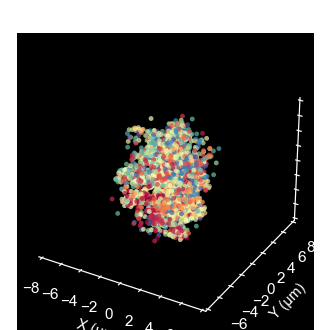

In [15]:
%matplotlib notebook
sel_lib = 'CTP13'
_decoded_groups = pd.read_hdf(ctp13_decode_args[sel_cell][4], f'{sel_lib}/spotGroups')
_zxys = _decoded_groups[['center_z', 'center_x', 'center_y']].values / 1000
_zxys = _zxys - np.nanmean(_zxys, axis=0)
_rids = _decoded_groups['region_id'].values

figure_width = 3
figure_dpi=100
marker_size = 10
marker_alpha = 0.7
_font_size = 7.5
plot_radius = 8
background_color = [0,0,0]
depthshade=False

fig = plt.figure(figsize=(figure_width, figure_width), dpi=figure_dpi)

ax3d = fig.add_subplot(111, projection='3d')
ax3d.set_facecolor(background_color)
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.9)
# turn off grid if needed
ax3d.grid(False)
ax3d.xaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax3d.yaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax3d.zaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))

_valid_inds = (np.isnan(_zxys).sum(1) == 0)
_sc = ax3d.scatter(_zxys[_valid_inds,1], _zxys[_valid_inds,2], _zxys[_valid_inds,0],
                   c=_rids, cmap='Spectral',
                   s=marker_size, depthshade=depthshade, 
                   alpha=marker_alpha,
                   linewidth=0,)
# axes limits
ax3d.axes.set_xlim3d(left=-plot_radius, right=plot_radius) 
ax3d.axes.set_ylim3d(bottom=-plot_radius, top=plot_radius) 
ax3d.axes.set_zlim3d(bottom=-plot_radius, top=plot_radius) 
# axes ticks
ax3d.set_xticks(np.arange(-plot_radius,plot_radius+1, 2))
ax3d.set_yticks(np.arange(-plot_radius,plot_radius+1, 2))
ax3d.set_zticks(np.arange(-plot_radius,plot_radius+1, 2))
# axes labels
ax3d.set_xlabel(f"X (\u03BCm)", fontsize=_font_size+2, labelpad=1)
ax3d.set_ylabel(f"Y (\u03BCm)", fontsize=_font_size+2, labelpad=1)
ax3d.set_zlabel(f"Z (\u03BCm)", fontsize=_font_size+2, labelpad=1)

# save pdf and png
fig.savefig(os.path.join(decoded_figure_folder, 
                         f"{os.path.basename(ctp13_decode_args[sel_cell][4]).replace('.hdf5', f'_decoded_{sel_lib}.png')}"),
            transparent=True)

## Process ALL

In [18]:
%%time
from ImageAnalysis3.classes.new_decoder import batch_process_SpotDecoder
import multiprocessing as mp
print(len(ctp13_decode_args))
with mp.Pool(44) as decode_pool:
    decode_results = decode_pool.starmap(batch_process_SpotDecoder, ctp13_decode_args, chunksize=1)
    decode_pool.close()
    decode_pool.join()
    decode_pool.terminate()

29049
Wall time: 1h 57min 32s


In [19]:
# Delete args to release RAM
del(ctp13_decode_args)
del(decode_results)

# 5. CTP12, sequential TSS for markergenes

## 5.1 prepare kwargs to map sequential CTP12

In [20]:
ctp12_codebook = pd.read_csv(r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-12_mop_markers\Summary_tables\CTP12-TSS_sequential-codebook.csv', header=0)
ctp12_codebook

,name,id,chr,Stv_91,Stv_32,Stv_92,Stv_33,Stv_94,Stv_35,Stv_95,...,Stv_106,Stv_45,Stv_107,Stv_46,Stv_109,Stv_48,Stv_118,Stv_50,Stv_119,Stv_53
0,5:31098237-31118237,Slc30a3,5,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7:45153949-45173949,Slc17a7,7,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2:158600767-158620767,Slc32a1,2,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2:70543072-70563072,Gad1,2,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5:30451932-30471932,Otof,5,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5,4:124976430-124996430,Rspo1,4,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
6,15:78196400-78216400,Pvalb,15,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
7,16:23880958-23900958,Sst,16,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,10:5629218-5649218,Vip,10,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,14:34364789-34384789,Sncg,14,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
ctp12_readout_df = pd.read_csv(r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-12_mop_markers\Summary_tables\CTP12-TSS_unique_readouts.csv', header=0)
ctp12_readout_df

,Bit,ReadoutName
0,1,Stv_91
1,2,Stv_32
2,3,Stv_92
3,4,Stv_33
4,5,Stv_94
5,6,Stv_35
6,7,Stv_95
7,8,Stv_36
8,9,Stv_99
9,10,Stv_37


In [22]:
%%time
from tqdm import tqdm
from ImageAnalysis3.classes import new_decoder
reload(ia.classes.new_decoder)
from ImageAnalysis3.classes.new_decoder import batch_process_SpotMapper

overwrite_decoder = False
verbose_decoder = True
return_decoder = False

ctp12_lib_name = 'CTP12tss'
ctp12_data_type = 'unique'
ctp12_decode_args = []

for _fov_id, _save_filename in zip(save_fov_ids, save_filenames):
    print(f"- Preparing decoding args for fov: {_fov_id},", end=' ')
    # load candidate spots for the fov
    cand_spot_filename = os.path.join(cand_spot_folder, ctp12_data_type,
                                      os.path.basename(_save_filename).replace('.hdf5', f'_CandSpots.csv') )
    if os.path.isfile(cand_spot_filename):
        _fov_spots_df = pd.read_csv(cand_spot_filename)
    else:
        print(f"-- skip")
        continue # skip if fov doesn't exist
        
    for _cell_id in np.unique(_fov_spots_df['cell_id']):
        # get decoder filename
        _decoder_filename = os.path.join(decoder_folder, f"Decoded_fov-{_fov_id}_cell-{_cell_id}.hdf5")
        # check if overwrite:
        if not overwrite_decoder and os.path.exists(_decoder_filename):
            # skip if exists
            with h5py.File(_decoder_filename, 'r') as _f:
                if ctp12_lib_name in _f.keys():
                    continue

        # get decoder filename
        _decoder_filename = os.path.join(decoder_folder, f"Decoded_fov-{_fov_id}_cell-{_cell_id}.hdf5")
        # get cell_df
        _cell_spots_df =_fov_spots_df[_fov_spots_df['cell_id']==_cell_id]
        # prepare args
        ctp12_decode_args.append(
            (ctp12_lib_name, _cell_spots_df, ctp12_codebook, ctp12_readout_df, _decoder_filename,
             pair_search_radius, pair_search_eps, overwrite_decoder, verbose_decoder, return_decoder)
        )
    print(len(ctp12_decode_args))

- Preparing decoding args for fov: 0, 110
- Preparing decoding args for fov: 1, 275
- Preparing decoding args for fov: 2, 316
- Preparing decoding args for fov: 3, 523
- Preparing decoding args for fov: 4, 711
- Preparing decoding args for fov: 5, 913
- Preparing decoding args for fov: 6, 1079
- Preparing decoding args for fov: 7, 1235
- Preparing decoding args for fov: 8, 1395
- Preparing decoding args for fov: 9, 1532
- Preparing decoding args for fov: 10, 1677
- Preparing decoding args for fov: 11, 1830
- Preparing decoding args for fov: 12, 1980
- Preparing decoding args for fov: 13, 2155
- Preparing decoding args for fov: 14, 2319
- Preparing decoding args for fov: 15, 2491
- Preparing decoding args for fov: 16, 2702
- Preparing decoding args for fov: 17, 2906
- Preparing decoding args for fov: 18, 2947
- Preparing decoding args for fov: 19, 3045
- Preparing decoding args for fov: 20, 3277
- Preparing decoding args for fov: 21, 3501
- Preparing decoding args for fov: 22, 3690
- Pr

## Process ALL

In [23]:
from ImageAnalysis3.classes.new_decoder import batch_process_SpotMapper, batch_process_SpotDecoder
import multiprocessing as mp

In [24]:
%%time
print(len(ctp12_decode_args))
with mp.Pool(32) as decode_pool:
    decode_results = decode_pool.starmap(batch_process_SpotMapper, ctp12_decode_args, chunksize=1)
    decode_pool.close()
    decode_pool.join()
    decode_pool.terminate()

28667
Wall time: 26min 2s


## load decoded results

In [27]:
sel_col = ['region_name', 'chr','start','end','center_intensity', 'center_z', 'center_x', 'center_y']

sel_filename = ctp12_decode_args[sel_cell][4]

ctp11_decoded_df = pd.read_hdf(sel_filename, 'CTP11/spotGroups')[sel_col]
ctp13_decoded_df = pd.read_hdf(sel_filename, 'CTP13/spotGroups')[sel_col]

ctp12_decoded_df = pd.read_hdf(sel_filename, 'CTP12tss/candSpots')[sel_col]

## 3D rendering of decoded spots

In [28]:
decoded_figure_folder = os.path.join(decoder_folder, 'Decoded_3D')
if not os.path.exists(decoded_figure_folder):
    os.makedirs(decoded_figure_folder)

In [29]:
from matplotlib import animation
plot_animation = True
angle = 3

from ImageAnalysis3.figure_tools import _dpi,_single_col_width,_double_col_width,_single_row_height,_ref_bar_length, _ticklabel_size,_ticklabel_width,_font_size
figure_width = _double_col_width
figure_dpi=100
background_color = [0,0,0]
marker_size = 8
marker_alpha = 1

depthshade=False

<IPython.core.display.Javascript object>


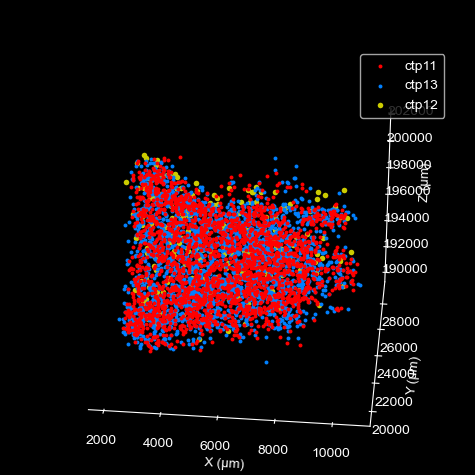

In [31]:
%matplotlib notebook
plt.rc('font', family='serif')
plt.rc('font', serif='Arial')
plt.style.use('dark_background')
fig = plt.figure(figsize=(figure_width, figure_width), dpi=figure_dpi)
ax3d = fig.add_subplot(111, projection='3d')
ax3d.set_facecolor(background_color)
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.9)
# turn off grid if needed
ax3d.grid(False)
ax3d.xaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax3d.yaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax3d.zaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))

#"ctp11"
_sc = ax3d.scatter(ctp11_decoded_df['center_z'], ctp11_decoded_df['center_x'], ctp11_decoded_df['center_y'], 
                   color=[1,0,0,1], 
                   s=marker_size, depthshade=depthshade, 
                   alpha=marker_alpha,
                   #edgecolors=_edge_colors, 
                   linewidth=0, label='ctp11')
#"ctp13"
_sc = ax3d.scatter(ctp13_decoded_df['center_z'], ctp13_decoded_df['center_x'], ctp13_decoded_df['center_y'], 
                   color=[0,0.5,1,1], 
                   s=marker_size, depthshade=depthshade, 
                   alpha=marker_alpha,
                   #edgecolors=_edge_colors, 
                   linewidth=0, label='ctp13')
#"ctp12"
_sc = ax3d.scatter(ctp12_decoded_df['center_z'], ctp12_decoded_df['center_x'], ctp12_decoded_df['center_y'], 
                   color=[0.8,0.8,0,1], 
                   s=marker_size*2, depthshade=depthshade, 
                   alpha=1,
                   #edgecolors=_edge_colors, 
                   linewidth=0, label='ctp12')
ax3d.legend()

# axes labels
ax3d.set_xlabel(f"X (\u03BCm)", fontsize=_font_size+2, labelpad=1)
ax3d.set_ylabel(f"Y (\u03BCm)", fontsize=_font_size+2, labelpad=1)
ax3d.set_zlabel(f"Z (\u03BCm)", fontsize=_font_size+2, labelpad=1)
if plot_animation:
    def rotate3D(angle):
         ax3d.view_init(azim=angle)
    ani = animation.FuncAnimation(fig, rotate3D, frames=np.arange(0, 360*2, angle), interval=50)
    ani.save(os.path.join(decoded_figure_folder, f"3D_{os.path.basename(sel_filename).replace('.hdf5','.gif')}"), 
             writer=animation.PillowWriter(fps=30), )
fig.show()

# Exporting dataset for Blair

In [38]:
reload(ia.classes.picker)

<module 'ImageAnalysis3.classes.picker' from 'E:\\Users\\puzheng\\Documents\\ImageAnalysis3\\classes\\picker.py'>

In [39]:
from ImageAnalysis3.classes.picker import SpotPicker
from tqdm import tqdm
import re

decoder_file_regex = r'Decoded_fov-(?P<fovId>[0-9]+)_cell-(?P<cellId>[0-9]+).hdf5'
decoder_filenames = [os.path.join(decoder_folder, _fl) for _fl in tqdm(os.listdir(decoder_folder)) 
                     if re.search(decoder_file_regex, _fl) is not None
                    ]
# sort
decoder_filenames = [_fl for _fl in sorted(decoder_filenames,
                                          key=lambda _fl: (int(re.search(decoder_file_regex, _fl).groupdict()['fovId']), 
                                           int(re.search(decoder_file_regex, _fl).groupdict()['cellId'])) )
                    ]

100%|████████████████████████████████████████████████████████████████████████| 86758/86758 [00:00<00:00, 289357.11it/s]


In [7]:
export_folder = r'\\10.245.74.158\Chromatin_NAS_8\Exported_data\20220316-Export_new_v2'
if not os.path.exists(export_folder):
    os.makedirs(export_folder)
    print(f"Creating export_folder: {export_folder}")
else:
    print(f"Use export_folder: {export_folder}")

Use export_folder: \\10.245.74.158\Chromatin_NAS_8\Exported_data\20220316-Export_new_v2


### load dict from fovCellId_2_class

In [8]:
%%time
fovcell_2_uid = {}
for _fov_id, _save_filename in zip(save_fov_ids, save_filenames):
    # segmentation filename
    _segmentation_savefile = os.path.join(segmentation_folder, 
        os.path.basename(_save_filename).replace('.hdf5', '_Segmentation.hdf5') )
    
    with h5py.File(_segmentation_savefile, 'r') as _f:
        for _fov_id in _f.keys():
            _fov_group = _f[_fov_id]
            _uid_group = _fov_group['cell_2_uid']
            for _cell_id in _uid_group.keys():
                fovcell_2_uid[(_fov_id, _cell_id)] = _uid_group[_cell_id][:][0].decode()
import scanpy as sc
# load cell type info
merfish_cluster_file = r'\\mendel\Mendel_SSD3\MERFISH_Analysis\Merged_MOP\manual_labeled_data.h5ad'
merfish_df = sc.read_h5ad(merfish_cluster_file)
print(np.unique(merfish_df.obs['experiment']) )
# load specifically this experiment
sel_exp = '20220329'
sel_obs = merfish_df.obs.loc[merfish_df.obs['experiment']==sel_exp]
uid_2_class = {_uid:_class for _uid, _class in zip(sel_obs.index, sel_obs['subclass_manual_label'])}
print(len(uid_2_class))
# assemble fovcell_2_class dict
fovcell_2_class = {}
for _decoder_fl in tqdm(decoder_filenames):
    _reg_match = re.search(decoder_file_regex, _decoder_fl)
    _fov_id, _cell_id = _reg_match.groupdict()['fovId'], _reg_match.groupdict()['cellId']
    if (_fov_id, _cell_id) in fovcell_2_uid:
        _uid = fovcell_2_uid[ (_fov_id, _cell_id) ]
        if _uid in uid_2_class:
            fovcell_2_class[(_fov_id, _cell_id)] = uid_2_class[_uid]
        else:
            fovcell_2_class[(_fov_id, _cell_id)] = 'other'

0 117
1 284
2 329
3 544
4 741
5 960
6 1136
7 1296
8 1458
9 1596
10 1750
11 1918
12 2072
13 2252
14 2424
15 2608
16 2825
17 3034
18 3078
19 3180
20 3420
21 3650
22 3848
23 4048
24 4218
25 4374
26 4486
27 4624
28 4799
29 4974
30 5208
31 5413
32 5688
33 5905
34 5929
35 6139
36 6308
37 6571
38 6806
39 7025
40 7241
41 7437
42 7664
43 7901
44 7981
45 8137
46 8324
47 8479
48 8643
49 8822
50 9010
51 9246
52 9425
53 9473
54 9493
55 9647
56 9901
57 10057
58 10227
59 10372
60 10554
61 10742
62 10909
63 11088
64 11221
65 11388
66 11604
67 11849
68 11936
69 11962
70 12099
71 12352
72 12544
73 12741
74 12957
75 13123
76 13160
77 13201
78 13211
79 13238
80 13299
81 13399
82 13589
83 13793
84 14009
85 14220
86 14474
87 14754
88 15020
89 15214
90 15310
91 15582
92 15829
93 16065
94 16237
95 16423
96 16604
97 16777
98 16976
99 17169
100 17404
101 17618
102 17839
103 18040
104 18278
105 18484
106 18690
107 18875
108 19063
109 19255
110 19426
111 19630
112 19842
113 19963
114 20118
115 20279
116 20458
117

['20220304' '20220329' '20220415' '20220418']
17840


100%|████████████████████████████████████████████████████████████████████████| 29070/29070 [00:00<00:00, 245849.20it/s]


## export

In [45]:
min_decoded_num = 400

for _decoder_fl in tqdm(decoder_filenames):
    _reg_match = re.search(decoder_file_regex, _decoder_fl)
    _fov_id, _cell_id = _reg_match.groupdict()['fovId'], _reg_match.groupdict()['cellId']
    # skip other
    if fovcell_2_class[(_fov_id, _cell_id)] == 'other':
        continue
    # export info
    export_filename = os.path.join(export_folder, f"Decoded_Fov-{_fov_id}.hdf5")
    #if os.path.exists(export_filename) and f"Cell-{_cell_id}" in h5py.File(export_filename).keys():
    #    continue
    # load
    _cls = SpotPicker(_decoder_fl, verbose=False, save_file=None)
    _cls._load_decoded()
    _cls._merge_decoded()
    if not hasattr(_cls, 'merged_coords'):
        continue
    # save
    if len(_cls.merged_coords) > min_decoded_num:
        _cls.merged_coords['subclass'] = fovcell_2_class[(_fov_id, _cell_id)]
        _cls.merged_coords.to_hdf(export_filename, f"Cell-{_cell_id}")
    

  0%|                                                                                        | 0/29070 [00:00<?, ?it/s]E:\Users\puzheng\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-5'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*`; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  0%|                                                                              | 4/29070 [00:00<1:01:40,  7.85it/s]E:\Users\puzheng\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-6'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  0%|                                   

  0%|▎                                                                           | 130/29070 [00:28<5:15:51,  1.53it/s]E:\Users\puzheng\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-19'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  0%|▎                                                                           | 131/29070 [00:28<5:10:59,  1.55it/s]E:\Users\puzheng\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-20'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  0%|▎                                                                           | 130/29070 [00:28<5:15:51,  1.53it/s]E:\Users\puzheng\anaconda3\envs\ia3_postanalysis\lib\site-pac

  1%|▍                                                                           | 187/29070 [00:59<4:39:09,  1.72it/s]E:\Users\puzheng\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-76'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  1%|▍                                                                           | 188/29070 [00:59<4:36:41,  1.74it/s]E:\Users\puzheng\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-77'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  1%|▍                                                                           | 187/29070 [00:59<4:39:09,  1.72it/s]E:\Users\puzheng\anaconda3\envs\ia3_postanalysis\lib\site-pac

  1%|▌                                                                           | 224/29070 [01:12<2:16:08,  3.53it/s]E:\Users\puzheng\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-113'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  1%|▌                                                                           | 225/29070 [01:13<3:07:06,  2.57it/s]E:\Users\puzheng\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-114'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  1%|▌                                                                           | 224/29070 [01:12<2:16:08,  3.53it/s]E:\Users\puzheng\anaconda3\envs\ia3_postanalysis\lib\site-p

  1%|▋                                                                           | 247/29070 [01:23<2:29:49,  3.21it/s]E:\Users\puzheng\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-137'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  1%|▋                                                                           | 248/29070 [01:24<3:54:28,  2.05it/s]E:\Users\puzheng\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-138'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  1%|▋                            

  1%|▉                                                                           | 346/29070 [01:48<3:46:00,  2.12it/s]E:\Users\puzheng\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-28'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  1%|▉                                                                          | 365/29070 [02:03<10:55:25,  1.37s/it]E:\Users\puzheng\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-47'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  1%|▉                              

  1%|█▏                                                                          | 433/29070 [03:03<9:46:03,  1.23s/it]E:\Users\puzheng\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-117'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  1%|█▏                                                                          | 435/29070 [03:04<7:58:26,  1.00s/it]E:\Users\puzheng\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-118'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  1%|█▏                           

  2%|█▎                                                                          | 484/29070 [03:34<4:39:05,  1.71it/s]E:\Users\puzheng\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-169'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  2%|█▎                                                                          | 486/29070 [03:36<5:59:48,  1.32it/s]E:\Users\puzheng\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-171'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  2%|█▎                           

  2%|█▎                                                                          | 505/29070 [03:52<6:15:48,  1.27it/s]E:\Users\puzheng\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-190'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  2%|█▎                                                                          | 506/29070 [03:53<6:59:11,  1.14it/s]E:\Users\puzheng\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-191'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*  2%|█▎                                                                          | 505/29070 [03:52<6:15:48,  1.27it/s]E:\Users\puzheng\anaconda3\envs\ia3_postanalysis\lib\site-p

  2%|█▋                                                                          | 628/29070 [05:28<7:51:56,  1.00it/s]E:\Users\puzheng\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-102'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  2%|█▋                                                                          | 632/29070 [05:30<6:33:43,  1.20it/s]E:\Users\puzheng\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-105'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  2%|█▋                           

  4%|██▊                                                                        | 1066/29070 [09:12<2:37:43,  2.96it/s]E:\Users\puzheng\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-143'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  4%|██▉                                                                        | 1150/29070 [10:11<8:11:50,  1.06s/it]E:\Users\puzheng\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-53'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
  5%|███▌                          

 11%|████████▌                                                                  | 3299/29070 [32:33<3:46:24,  1.90it/s]E:\Users\puzheng\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-223'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 11%|████████▌                                                                  | 3300/29070 [32:34<4:08:45,  1.73it/s]E:\Users\puzheng\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-224'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]* 11%|████████▌                                                                  | 3299/29070 [32:33<3:46:24,  1.90it/s]E:\Users\puzheng\anaconda3\envs\ia3_postanalysis\lib\site-p

 19%|██████████████▏                                                            | 5481/29070 [52:53<1:59:49,  3.28it/s]E:\Users\puzheng\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-239'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 19%|██████████████▏                                                            | 5484/29070 [52:55<2:41:37,  2.43it/s]E:\Users\puzheng\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-241'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 19%|██████████████▏              

 24%|█████████████████▊                                                         | 6886/29070 [57:53<2:18:38,  2.67it/s]E:\Users\puzheng\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-210'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 26%|██████████████████▉                                                      | 7534/29070 [1:05:36<2:19:34,  2.57it/s]E:\Users\puzheng\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-231'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 39%|████████████████████████████ 

-- No coordinate exists, skip.


 73%|█████████████████████████████████████████████████████▉                    | 21202/29070 [2:48:58<57:18,  2.29it/s]

-- No coordinate exists, skip.


 76%|███████████████████████████████████████████████████████▉                  | 21997/29070 [2:53:13<30:11,  3.90it/s]E:\Users\puzheng\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-240'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
 79%|██████████████████████████████████████████████████████████▊               | 23092/29070 [2:58:11<09:55, 10.04it/s]E:\Users\puzheng\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'Cell-253'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
100%|█████████████████████████████

In [44]:
import pandas as pd
np.unique(pd.read_hdf(export_filename, 'Cell-5')['num_spots'])

array([1, 2, 3], dtype=int64)